In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle

In [ ]:
!pip install mlflow

**1)Reading the dataset and loading the correlations with the target**

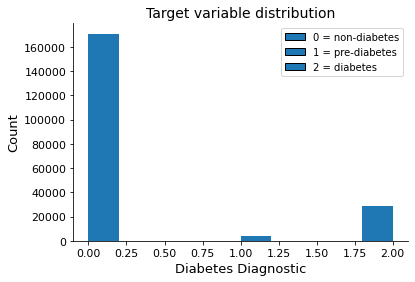

84.22 % of training data has label  0
1.82 % of training data has label  1
13.96 % of training data has label  2


In [ ]:
#data = np.random.rayleigh(size=1000)*35

N, bins, patches = plt.hist(Y_train)

cmap = plt.get_cmap('jet')
low = cmap(0.5)
medium =cmap(0.25)
high = cmap(0.8)

#create legend
handles = [Rectangle((0,0),1,1,c,ec="k") for c in range(3)]
labels= ["0 = non-diabetes","1 = pre-diabetes", "2 = diabetes"]
plt.legend(handles, labels)

plt.title("Target variable distribution",fontsize = 14)
plt.xlabel("Diabetes Diagnostic", fontsize=13)  
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=11)  
plt.yticks(fontsize=11)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()
d = dict(Counter(Y_train))
for el in sorted(d):
  print(round(d[el]/Y_train.shape[0]*100,2),"% of training data has label ",int(el))

No handles with labels found to put in legend.


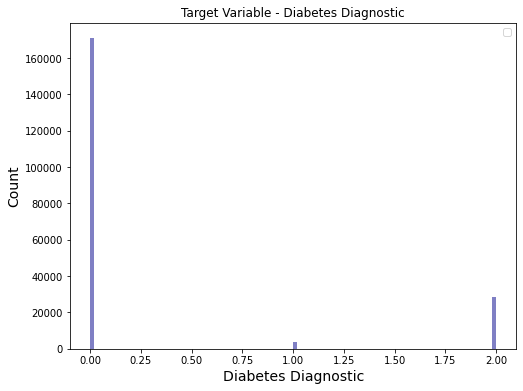

In [ ]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(8,6))
#plt.bar(Y_train, bins=100)
handles = [Rectangle((0,0),10,10,color=c,ec="k") for c in ["red","blue", "yellow"]]
labels= ["low","medium", "high"]
plt.legend(handles, labels)
plt.hist(Y_train, bins=100, alpha=0.5, color='darkblue')

plt.xlabel("Diabetes Diagnostic", size=14)
plt.ylabel("Count", size=14)
plt.title("Target Variable - Diabetes Diagnostic")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

In [ ]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
poly_corr = pd.read_csv('correlations.csv')                         #this CSV contains all the correlations with the target of the polynomial features which will be further created 
data = data.sample(frac=1)
print("Dataset size: ", data.shape)
print(data.columns)
print("\n",data.head())
print("\ndiabetes has label 0")
print("pre-diabetes has label 1")
print("non-diabetes has label 2\n")
d = dict(Counter(data['Diabetes_012'].values))
for el in d:
  print(round(d[el]/data.shape[0]*100,2),"% of data is label ",int(el))
data_noskew=data.copy()

Dataset size:  (253680, 22)
Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

         Diabetes_012  HighBP  HighChol  CholCheck  ...  Sex   Age  Education  Income
44553            0.0     0.0       0.0        0.0  ...  1.0   3.0        4.0     4.0
144157           0.0     0.0       1.0        1.0  ...  0.0  11.0        4.0     6.0
78586            0.0     0.0       0.0        1.0  ...  0.0   5.0        6.0     8.0
132449           0.0     0.0       1.0        1.0  ...  0.0   9.0        6.0     6.0
54319            0.0     1.0       1.0        1.0  ...  1.0   9.0        6.0     8.0

[5 rows x 22 columns]

diabetes has label 0
pre-diabetes has label 1
non-diabetes has label 2

84.24 % of data is label  0
13

In [ ]:
data.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI^0.5*GenHlth^0.5', 'HighBP^0.5*GenHlth^1.5', 'BMI^1.0*GenHlth^1.0',
       'HighBP^1.0*GenHlth^1.5', 'BMI^1.0*GenHlth^1.5', 'BMI^1.0*GenHlth^2.0',
       'HighBP^1.5*GenHlth^1.5', 'HighBP^2.0*GenHlth^1.5',
       'HighBP^2.5*GenHlth^1.5'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


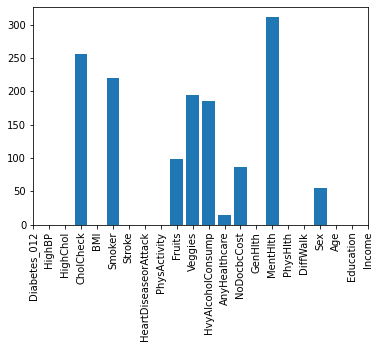

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = list(data.columns)

# Perform feature selection
selector = SelectKBest(f_classif)
selector.fit(data[predictors], data["Diabetes_012"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [ ]:
data.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
kbest_data = data[:len(data)//10].copy()
kbest_data.pop('HighBP')
kbest_data.pop('HighChol')
kbest_data.pop('BMI')
kbest_data.pop('Stroke')
kbest_data.pop('HeartDiseaseorAttack')
kbest_data.pop('PhysActivity')
kbest_data.pop('GenHlth')
kbest_data.pop('PhysHlth')
kbest_data.pop('DiffWalk')
kbest_data.pop('Age')
kbest_data.pop('Education')
kbest_data.pop('Income')


2961      2.0
160581    8.0
36201     3.0
87068     4.0
189169    8.0
         ... 
66434     8.0
218222    7.0
24043     7.0
11366     7.0
106047    8.0
Name: Income, Length: 25368, dtype: float64

In [ ]:
data=kbest_data
data.head()

,Diabetes_012,CholCheck,Smoker,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,MentHlth,Sex
194346,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31209,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
70445,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
241720,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
250993,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,30.0,0.0


In [ ]:
print("Number of null values for every feature and the target")
print(data.isnull().sum())
print("\nNumber of N/A values for every feature and the target")
data.isna().sum()

In [ ]:
data2 = pd.DataFrame(data['Diabetes_012'], data['BMI'])

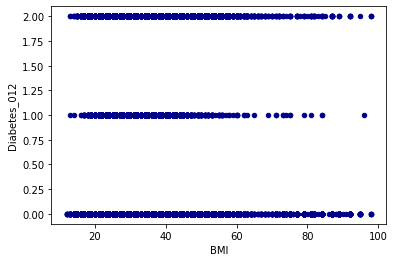

In [ ]:
plot = data.plot.scatter(x='BMI', y='Diabetes_012', c='DarkBlue')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ebbe02190>,
      dtype=object)

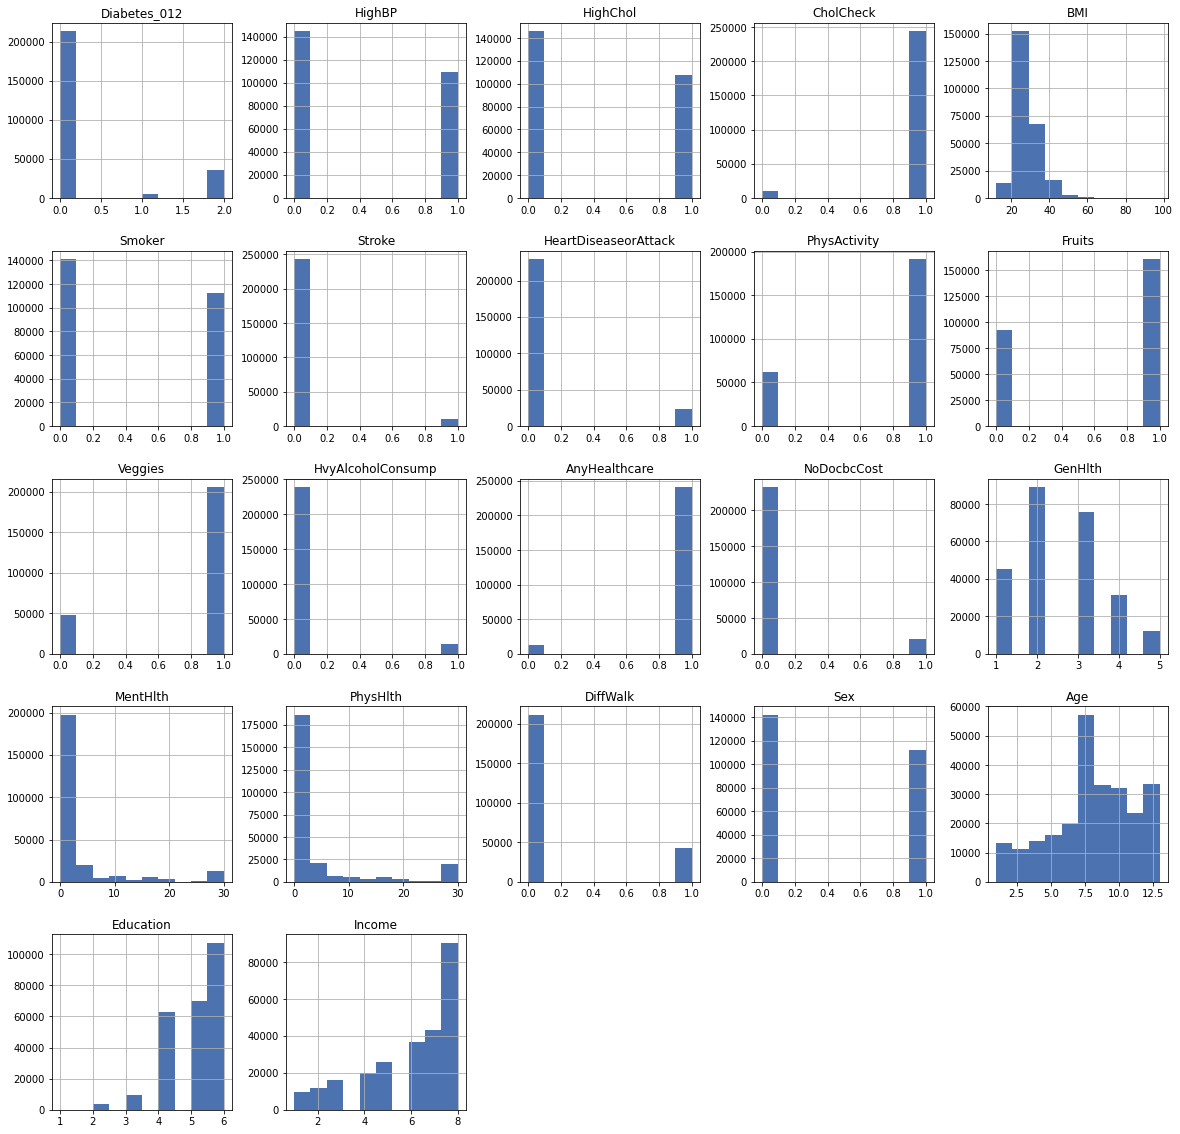

In [ ]:
data.hist(figsize=(20,20))

In [ ]:
print("Sets of all the values for every feature")

for column in list(data.columns):
  print(column,": ",len(list(set(data[column].values))),set(data[column].values))             #check for outliers

Sets of all the values for every feature
Diabetes_012 :  3 {0.0, 1.0, 2.0}
HighBP :  2 {0.0, 1.0}
HighChol :  2 {0.0, 1.0}
CholCheck :  2 {0.0, 1.0}
BMI :  84 {12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 95.0, 96.0, 98.0}
Smoker :  2 {0.0, 1.0}
Stroke :  2 {0.0, 1.0}
HeartDiseaseorAttack :  2 {0.0, 1.0}
PhysActivity :  2 {0.0, 1.0}
Fruits :  2 {0.0, 1.0}
Veggies :  2 {0.0, 1.0}
HvyAlcoholConsump :  2 {0.0, 1.0}
AnyHealthcare :  2 {0.0, 1.0}
NoDocbcCost :  2 {0.0, 1.0}
GenHlth :  5 {1.0, 2.0, 3.0, 4.0, 5.0}
MentHlth :  31 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 

In [ ]:
print("Correlation matrix\n")
corr_mx = data.corr() # uses pearson correlation coeff by default

for idx in range(corr_mx.shape[0]):
    corr_mx.iloc[idx, idx] = 0

sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(corr_mx, annot=True)
plt.show()

In [ ]:
corr_mx.max()

**Polynomial Features**

In [ ]:
additional_features = poly_corr[poly_corr['corr'].abs()>0.34]['Polynomial features'].values
for ftr in additional_features:
  el = ftr.split()
  data["".join(el)] = (data[el[0]]**(float(el[2]))) * (data[el[4]]**(float(el[-1])))

#remove polynomial features with relatively high skewness
data.pop('HighBP^0.5*GenHlth^2.0')
data.pop('HighBP^1.0*GenHlth^2.0')
data.pop('HighBP^1.5*GenHlth^2.0')
data.pop('HighBP^2.0*GenHlth^2.0')
data.pop('HighBP^2.5*GenHlth^2.0')

44553     0.0
144157    0.0
78586     0.0
132449    0.0
54319     4.0
         ... 
248607    0.0
221417    0.0
252150    0.0
98264     1.0
112707    0.0
Name: HighBP^2.5*GenHlth^2.0, Length: 253680, dtype: float64

In [ ]:
X.shape

(253680, 21)

**3) Train/Test split**

In [ ]:
X = data.copy()
Y = X.pop('Diabetes_012')
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=20)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_noskew = data_noskew.copy()
Y_noskew = X_noskew.pop('Diabetes_012')
X_train_noskew, X_test_noskew, Y_train_noskew, Y_test_noskew = train_test_split( X_noskew, Y_noskew, test_size=0.2, random_state=20)

(202944, 30)
(202944,)
(50736, 30)
(50736,)


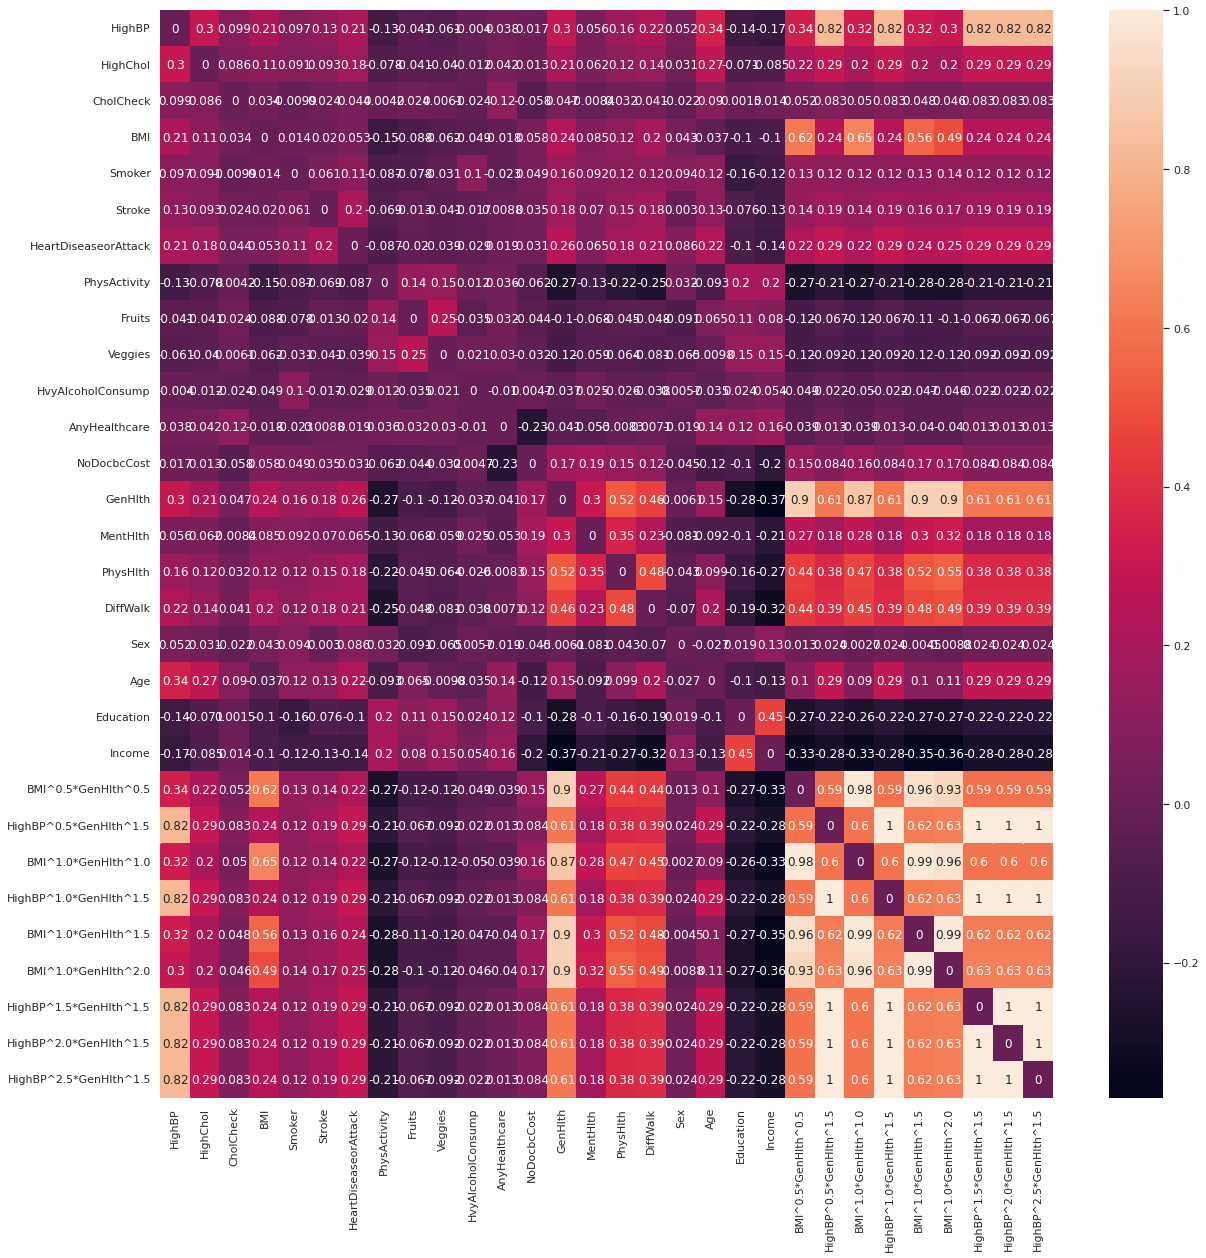

In [20]:
corr_mx = X.corr() # uses pearson correlation coeff by default

for idx in range(corr_mx.shape[0]):
    corr_mx.iloc[idx, idx] = 0

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_mx, annot=True)
plt.show()

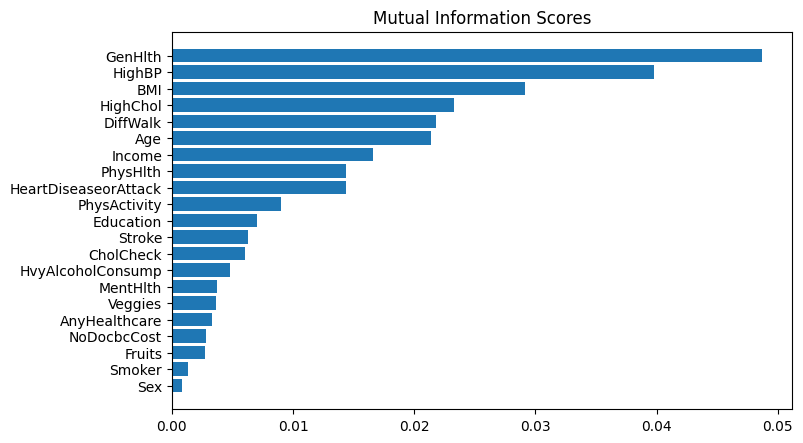

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
mi_scores = make_mi_scores(X_train, Y_train, discrete_features=True)
plot_mi_scores(mi_scores)

In [ ]:
print(X_train.columns)

Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI^0.5*GenHlth^0.5', 'HighBP^0.5*GenHlth^1.5', 'BMI^1.0*GenHlth^1.0',
       'HighBP^1.0*GenHlth^1.5', 'BMI^1.0*GenHlth^1.5', 'BMI^1.0*GenHlth^2.0',
       'HighBP^1.5*GenHlth^1.5', 'HighBP^2.0*GenHlth^1.5',
       'HighBP^2.5*GenHlth^1.5'],
      dtype='object')


**Adjust skewed data**
(train set)

So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models.

In [ ]:
#skew =0(no skew) >0(right skew) <0(left skew)


#For right skewed data apply log(1+x)
log_columns = X_train.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns>0.75]
right_skewed = list(log_columns.index)
print("\nRight skewed features:")
print(log_columns)
for col in log_columns.index:
    X_train[col] = np.log1p(X_train[col])

#For left  skewed data apply x^3
left_skew = X_train.skew().sort_values(ascending=False)
left_skew = left_skew.loc[left_skew<-0.75]
print("\nLeft skewed features:")
print(left_skew)
for col in left_skew.index:
    X_train[col] = X_train[col].pow(3)


#Data after adjusting the skewness   
print("\n",X_train.skew().sort_values(ascending=False))


Right skewed features:
Stroke                    4.666545
HvyAlcoholConsump         3.848861
NoDocbcCost               2.997275
HeartDiseaseorAttack      2.772275
MentHlth                  2.725873
PhysHlth                  2.204716
BMI                       2.106149
BMI^1.0*GenHlth^2.0       1.856619
DiffWalk                  1.765698
BMI^1.0*GenHlth^1.5       1.524266
BMI^1.0*GenHlth^1.0       1.272311
HighBP^2.0*GenHlth^1.5    1.256245
HighBP^2.5*GenHlth^1.5    1.256245
HighBP^0.5*GenHlth^1.5    1.256245
HighBP^1.5*GenHlth^1.5    1.256245
HighBP^1.0*GenHlth^1.5    1.256245
dtype: float64

Left skewed features:
Education       -0.777366
Income          -0.890031
PhysActivity    -1.191346
Veggies         -1.587032
AnyHealthcare   -4.185199
CholCheck       -4.864357
dtype: float64

 Stroke                    4.666545
HvyAlcoholConsump         3.848861
NoDocbcCost               2.997275
HeartDiseaseorAttack      2.772275
DiffWalk                  1.765698
MentHlth                  1.52

**Adjust skewed data** (test set)

In [ ]:
log_columns = X_test.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns>0.75]
right_skewed = list(log_columns.index)
for col in log_columns.index:
    X_test[col] = np.log1p(X_test[col])

left_skew = X_test.skew().sort_values(ascending=False)
left_skew = left_skew.loc[left_skew<-0.75]
for col in left_skew.index:
    X_test[col] = X_test[col].pow(3)

print(X_test.skew().sort_values(ascending=False))

Stroke                    4.621110
HvyAlcoholConsump         3.875500
NoDocbcCost               2.987463
HeartDiseaseorAttack      2.804993
DiffWalk                  1.807311
MentHlth                  1.518775
PhysHlth                  1.257232
BMI                       0.711069
HighBP^2.0*GenHlth^1.5    0.603794
HighBP^2.5*GenHlth^1.5    0.603794
HighBP^0.5*GenHlth^1.5    0.603794
HighBP^1.5*GenHlth^1.5    0.603794
HighBP^1.0*GenHlth^1.5    0.603794
GenHlth                   0.425572
BMI^0.5*GenHlth^0.5       0.406170
HighChol                  0.299104
HighBP                    0.293728
Sex                       0.232482
Smoker                    0.225327
Income                   -0.122400
Education                -0.179040
BMI^1.0*GenHlth^1.0      -0.240982
BMI^1.0*GenHlth^1.5      -0.341611
Age                      -0.356257
BMI^1.0*GenHlth^2.0      -0.383935
Fruits                   -0.554815
PhysActivity             -1.212500
Veggies                  -1.613315
AnyHealthcare       

**5) Scale data** (min-max scaler)



*   (x-min)/(max-min)
*   standardization uses mean 0 and std=1



In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

for col in X_train.columns:
  X_train[col] = mm_scaler.fit_transform(X_train[[col]])

for col in X_train_noskew.columns:
  X_train_noskew[col] = mm_scaler.fit_transform(X_train_noskew[[col]])

for col in X_test.columns:
  X_test[col] = mm_scaler.fit_transform(X_test[[col]])

**Skew/noskew histograms**

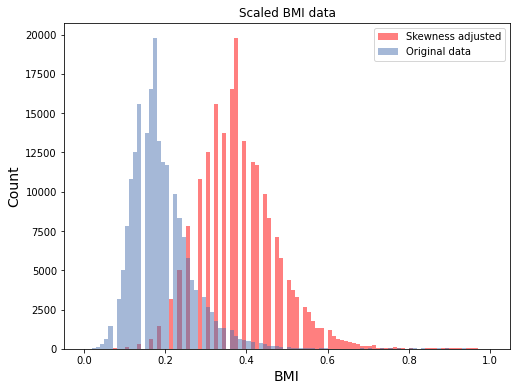

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(X_train['BMI'], bins=100, alpha=0.5, label="Skewness adjusted", color='red')
plt.hist(X_train_noskew['BMI'], bins=100, alpha=0.5, label="Original data")

plt.xlabel("BMI", size=14)
plt.ylabel("Count", size=14)
plt.title("Scaled BMI data")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

#X_train['BMI'].hist()
#X_train_noskew['BMI'].hist()

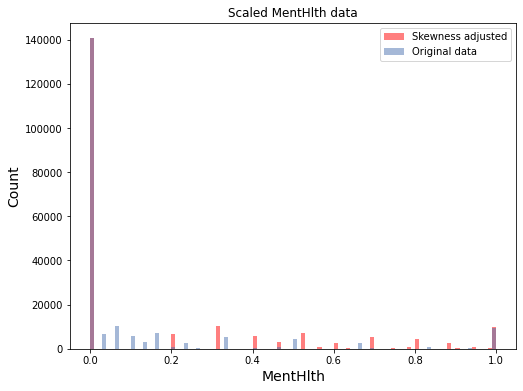

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(X_train['MentHlth'], bins=100, alpha=0.5, label="Skewness adjusted", color='red')
plt.hist(X_train_noskew['MentHlth'], bins=100, alpha=0.5, label="Original data")

plt.xlabel("MentHlth", size=14)
plt.ylabel("Count", size=14)
plt.title("Scaled MentHlth data")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")



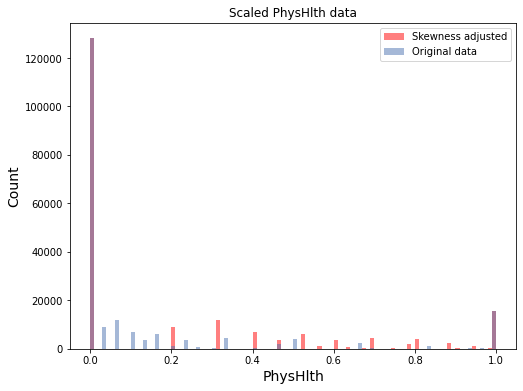

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(X_train['PhysHlth'], bins=100, alpha=0.5, label="Skewness adjusted", color='red')
plt.hist(X_train_noskew['PhysHlth'], bins=100, alpha=0.5, label="Original data")

plt.xlabel("PhysHlth", size=14)
plt.ylabel("Count", size=14)
plt.title("Scaled PhysHlth data")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")



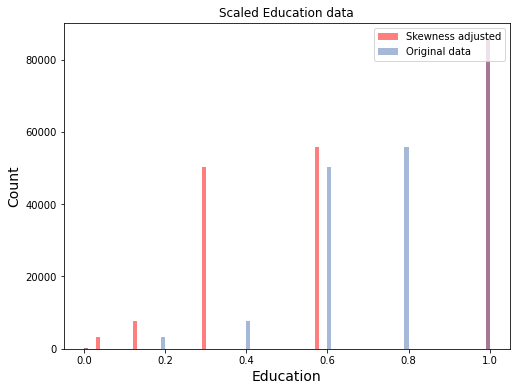

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(X_train['Education'], bins=100, alpha=0.5, label="Skewness adjusted", color='red')
plt.hist(X_train_noskew['Education'], bins=100, alpha=0.5, label="Original data")

plt.xlabel("Education", size=14)
plt.ylabel("Count", size=14)
plt.title("Scaled Education data")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

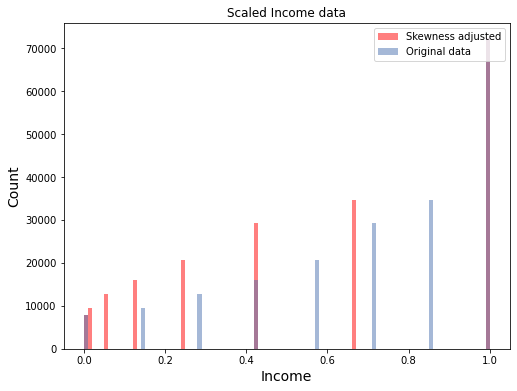

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(X_train['Income'], bins=100, alpha=0.5, label="Skewness adjusted", color='red')
plt.hist(X_train_noskew['Income'], bins=100, alpha=0.5, label="Original data")

plt.xlabel("Income", size=14)
plt.ylabel("Count", size=14)
plt.title("Scaled Income data")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

In [ ]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

for n in range(1,22):
    #create and fit the model
    PCAmod = PCA(n_components = n)
    PCAmod.fit(X_train)
    
    #Store the model and variance
    pca_list.append(pd.Series({'n':n, 'Model':PCAmod, 'Explained Variance':str(round(PCAmod.explained_variance_ratio_.sum()*100,2))+"%"}))
    
    #Calculate and store feature importances
    weights = PCAmod.explained_variance_ratio_.reshape(-1,1)/PCAmod.explained_variance_ratio_.sum() #add more weight to the most important PCs
    overall_contribution = np.abs(PCAmod.components_)*weights
    abs_feature_values = overall_contribution.sum(axis=0) # how every feature with their weightings comprise the PCs 
    feature_weight_list.append(pd.DataFrame({'n':n, 'features':X_train.columns, 'values':abs_feature_values/abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,Model,Explained Variance
n,,
1,PCA(n_components=1),18.13%
2,PCA(n_components=2),29.52%
3,PCA(n_components=3),40.2%
4,PCA(n_components=4),49.58%
5,PCA(n_components=5),57.3%
6,PCA(n_components=6),64.03%
7,PCA(n_components=7),69.65%
8,PCA(n_components=8),74.91%
9,PCA(n_components=9),78.74%


**6*)(Run only for input consisting in principal components) PCA**

In [ ]:
from sklearn.decomposition import PCA

#chose the smallest number of components that explain at least 90% of variance

#fit and transform data for the training set
pca = PCA(n_components = 2)
pca.fit(X_train)
X_pca_train=pca.transform(X_train)

#transform data for the test set
X_pca_test = pca.transform(X_test)

X_train=X_pca_train
X_test=X_pca_test
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(202944, 2)
(50736, 2)
(202944,)
(50736,)


**Grid search for hyperparam tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import classification_report

clf = svm.SVC(class_weight='balanced')
# defining parameter range
param_grid = {'C': [0.1],#, 1],#, 5, 10, 16],#, 100, 1000],
              'gamma': [ 0.1, 0.2, 0.3, 0.4, 0.5 ,0.6 ,0.7, 0.8, 0.9 ,1],#, 0.01],#, 0.001],# 0.0001],
              'kernel': ['poly'],#, 'rbf'],#, 'sigmoid']}
              'degree': [3,4,5]}
 
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_pca_train, Y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.1, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}
SVC(C=0.1, class_weight='balanced', degree=4, gamma=0.1, kernel='poly')


**Results**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef, accuracy_score, f1_score
from sklearn.metrics import classification_report
import mlflow

def custom_logging(y_true, y_pred, verbose = 1):
    mcc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)
    mse = mean_squared_error(y_true = y_true, y_pred = y_pred)
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred)
    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    f1 = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')

    mlflow.log_metric(key = 'acc_', value = acc)
    mlflow.log_metric(key = 'mae_', value = mae)
    mlflow.log_metric(key = 'mse_', value = mse)
    mlflow.log_metric(key = 'f1_', value = f1)
    mlflow.log_metric(key = 'mcc_', value = mcc)

    if verbose:
        print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))
        print(f"MAE: \t{mae}")
        print(f"MSE: \t{mse}")
        print(f"ACC: \t{acc}")
        print(f"MCC: \t{mcc}")
        svm_train_mcc = matthews_corrcoef(y_true, y_pred)
        svm_train_accuracy = accuracy_score(y_true, y_pred)
        svm_train_f1_score=f1_score(y_true, y_pred, average='weighted')
        print("F1-Score: ",svm_train_f1_score*100)
        print("Accuracy Score: ",svm_train_accuracy*100)

Text(66.5, 0.5, 'Truth')

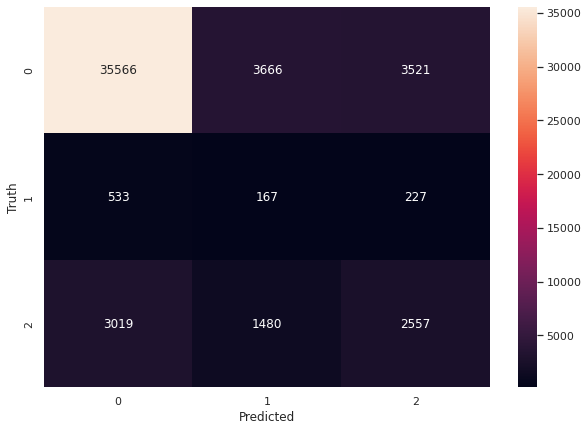

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
X_train.shape

(20294, 9)

**7) Results for:**

    

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

clf = BaggingClassifier(base_estimator=svm.SVC(C=0.1, kernel = 'poly', gamma = 0.2, degree = 3, class_weight='balanced'), n_estimators=20, max_samples=0.1, bootstrap=False, random_state=104, verbose = 10).fit(X_train,Y_train)
prediction = clf.predict(X_test)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished


kernel='poly' and class_weight='balanced' are constant

**a) base features 1,3,5**

*   C=0.1
*   gamma=0.1

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     42729
           1       0.03      0.28      0.05       904
           2       0.33      0.55      0.42      7103

    accuracy                           0.64     50736
   macro avg       0.44      0.50      0.42     50736
weighted avg       0.84      0.64      0.71     50736

MAE: 	0.5345908230842006
MSE: 	0.8834161147902869
ACC: 	0.6398218227688426
MCC: 	0.2726476191535446
F1-Score:  71.45603952363032
Accuracy Score:  63.98218227688426


Text(24.0, 0.5, 'Truth')

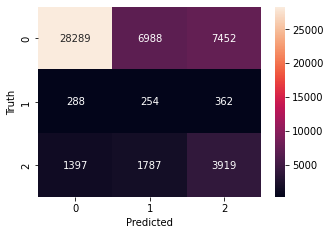

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**b) base features + skewness 1,3,4,5**

*   C=0.1
*   gamma=0.1

              precision    recall  f1-score   support

           0       0.95      0.67      0.78     42782
           1       0.03      0.27      0.05       921
           2       0.35      0.58      0.44      7033

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.85      0.65      0.72     50736

MAE: 	0.518822926521602
MSE: 	0.856413591926837
ACC: 	0.6499724061810155
MCC: 	0.28834089147019965
F1-Score:  72.26332879888614
Accuracy Score:  64.99724061810154


Text(24.0, 0.5, 'Truth')

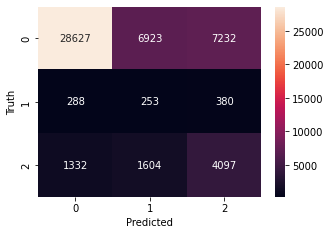

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**c) base features 1,3,5**

*   C=0.1
*   gamma=0.2



              precision    recall  f1-score   support

           0       0.95      0.67      0.79     42729
           1       0.03      0.25      0.05       904
           2       0.34      0.60      0.43      7103

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.84      0.65      0.72     50736

MAE: 	0.5288749605802586
MSE: 	0.8962275307473982
ACC: 	0.6548013245033113
MCC: 	0.29151926826698726
F1-Score:  72.36875029939031
Accuracy Score:  65.48013245033113


Text(24.0, 0.5, 'Truth')

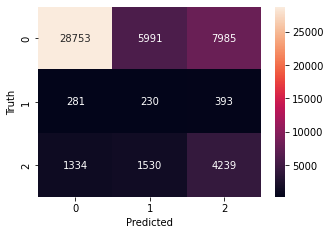

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**d) base features  + skewness 1,3,4,5**

*   C=0.1
*   gamma=0.2



              precision    recall  f1-score   support

           0       0.95      0.67      0.79     42782
           1       0.03      0.24      0.05       921
           2       0.34      0.63      0.44      7033

    accuracy                           0.66     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.85      0.66      0.72     50736

MAE: 	0.5314175339009776
MSE: 	0.9078366445916115
ACC: 	0.6567920214443393
MCC: 	0.30093233613117515
F1-Score:  72.43636324458414
Accuracy Score:  65.67920214443393


Text(24.0, 0.5, 'Truth')

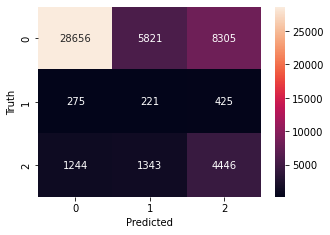

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**e) Base features + poly 1,2,3,5**

*   C=0.1
*   gamma=0.1

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     42591
           1       0.03      0.27      0.05       954
           2       0.35      0.55      0.43      7191

    accuracy                           0.64     50736
   macro avg       0.44      0.50      0.42     50736
weighted avg       0.84      0.64      0.72     50736

MAE: 	0.519847839798171
MSE: 	0.8484113844213182
ACC: 	0.6444339325134028
MCC: 	0.2783857740724818
F1-Score:  71.86436860616429
Accuracy Score:  64.44339325134027


Text(24.0, 0.5, 'Truth')

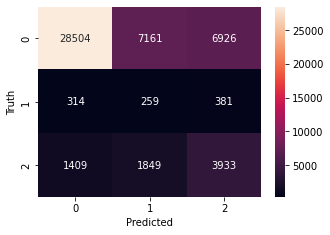

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**f) Base features + poly + skewness 1,2,3,4,5**

*   C=0.1
*   gamma=0.1

              precision    recall  f1-score   support

           0       0.95      0.67      0.79     42756
           1       0.03      0.28      0.05       918
           2       0.34      0.57      0.43      7062

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.84      0.65      0.72     50736

MAE: 	0.521444339325134
MSE: 	0.8655786818038473
ACC: 	0.6506228319142227
MCC: 	0.2847098292190008
F1-Score:  72.24457909197677
Accuracy Score:  65.06228319142227


Text(24.0, 0.5, 'Truth')

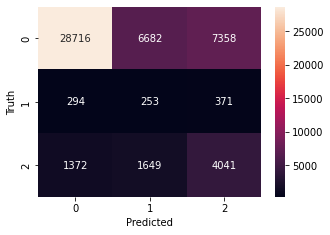

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**g) Base features + poly 1,2,3,5**

*   C=0.1
*   gamma=0.2

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     42591
           1       0.03      0.22      0.05       954
           2       0.34      0.61      0.43      7191

    accuracy                           0.66     50736
   macro avg       0.44      0.50      0.42     50736
weighted avg       0.84      0.66      0.73     50736

MAE: 	0.5277909176915799
MSE: 	0.9035793125197099
ACC: 	0.6601032797224851
MCC: 	0.2946496672939283
F1-Score:  72.55586521955509
Accuracy Score:  66.0103279722485


Text(24.0, 0.5, 'Truth')

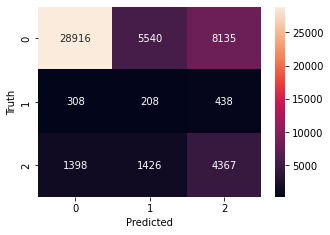

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**h) Base features + poly + skewness 1,2,3,4,5**

*   C=0.1
*   gamma=0.2

              precision    recall  f1-score   support

           0       0.95      0.68      0.79     42756
           1       0.03      0.22      0.05       918
           2       0.33      0.62      0.43      7062

    accuracy                           0.66     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.85      0.66      0.73     50736

MAE: 	0.5294268369599495
MSE: 	0.9101426994638915
ACC: 	0.6609310942920215
MCC: 	0.29695905407013246
F1-Score:  72.69219492515217
Accuracy Score:  66.09310942920214


Text(24.0, 0.5, 'Truth')

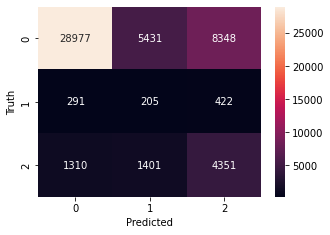

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**j) Base features + poly + skewness + 2 PCs 1,2,3,4,5,6**

*   C=0.1
*   gamma=0.2

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     42851
           1       0.03      0.17      0.05       917
           2       0.40      0.37      0.38      6968

    accuracy                           0.75     50736
   macro avg       0.45      0.46      0.43     50736
weighted avg       0.82      0.75      0.79     50736

MAE: 	0.37673446862188587
MSE: 	0.6345789971617786
ACC: 	0.7521877956480606
MCC: 	0.2660124132152895
F1-Score:  78.58699670612317
Accuracy Score:  75.21877956480606


Text(24.0, 0.5, 'Truth')

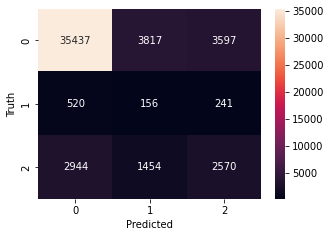

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**k) Base features + poly + skewness + 14 PCs 1,2,3,4,5,6**

C=0.1
gamma=0.1

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     42902
           1       0.03      0.19      0.05       872
           2       0.41      0.33      0.37      6962

    accuracy                           0.76     50736
   macro avg       0.45      0.46      0.43     50736
weighted avg       0.82      0.76      0.79     50736

MAE: 	0.36453405865657523
MSE: 	0.6132726269315674
ACC: 	0.7598352254809209
MCC: 	0.26093796353791593
F1-Score:  78.96553346213115
Accuracy Score:  75.98352254809208


Text(24.0, 0.5, 'Truth')

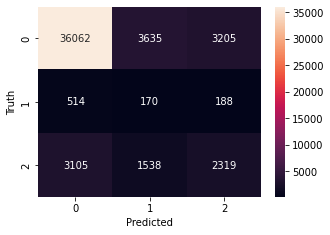

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**l) Base features + poly + skewness + 14 PCs 1,2,3,4,5,6**

C=0.1
gamma=0.2

              precision    recall  f1-score   support

           0       0.93      0.73      0.82     42902
           1       0.03      0.19      0.05       872
           2       0.34      0.53      0.42      6962

    accuracy                           0.70     50736
   macro avg       0.43      0.48      0.43     50736
weighted avg       0.84      0.70      0.75     50736

MAE: 	0.47445600756859035
MSE: 	0.8146483759066541
ACC: 	0.6956401766004415
MCC: 	0.2805326144762348
F1-Score:  75.17405346252839
Accuracy Score:  69.56401766004416


Text(24.0, 0.5, 'Truth')

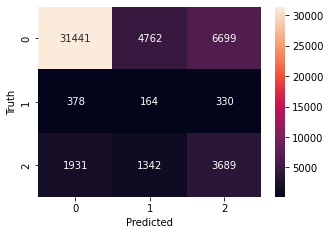

In [ ]:
custom_logging(Y_test, prediction)
cm=confusion_matrix(Y_test,prediction)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **IGNORE THE CODE BELOW**

In [ ]:
custom_logging(Y_test, prediction) # C=0.2 polynomial features, adjusted skewness, 14 principal components

In [ ]:
custom_logging(Y_test, prediction) # C=0.2 adjusted skewness for base features

              precision    recall  f1-score   support

           0       0.95      0.68      0.79     42744
           1       0.03      0.20      0.05       943
           2       0.33      0.65      0.44      7049

    accuracy                           0.67     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.84      0.67      0.73     50736

MAE: 	0.5370545569221066
MSE: 	0.9423683380637023
ACC: 	0.6656023336486913
MCC: 	0.3040761801466852
F1-Score:  72.72802892276066
Accuracy Score:  66.56023336486912


In [ ]:
custom_logging(Y_test, prediction) # C=0.1 base features

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     42723
           1       0.03      0.25      0.06       957
           2       0.34      0.60      0.43      7056

    accuracy                           0.66     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.84      0.66      0.72     50736

MAE: 	0.5248935666982024
MSE: 	0.8897626931567328
ACC: 	0.6575409965310628
MCC: 	0.2908320889252972
F1-Score:  72.47485597831614
Accuracy Score:  65.75409965310628
